In [24]:
from PySigmoid import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>


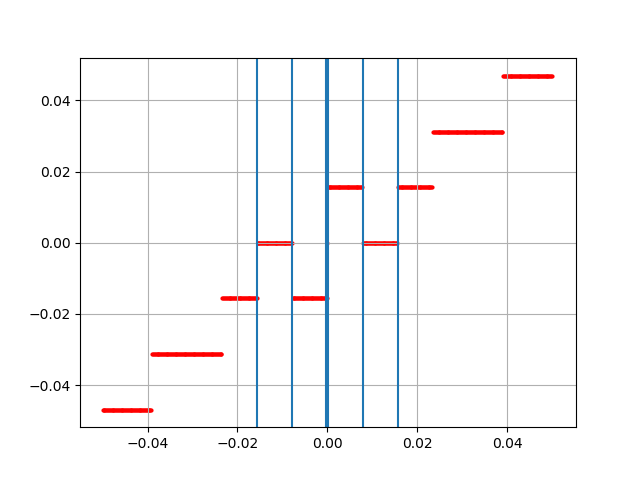

In [35]:
set_posit_env(8,0)
plt.figure()
plt.scatter(0,0,marker='.', c='r', linewidths=0.01)
for p in np.linspace(-0.05, 0.05, 500):
#     print(Posit(p))
    plt.scatter(p, Posit(p),marker='.', c='r', linewidths=0.01)

plt.axvline(x=1/64)
plt.axvline(x=1/(64**2))
plt.axvline(x=(1/(64**2)+1/64)/2)
plt.axvline(x=-1/64)
plt.axvline(x=-1/(64**2))
plt.axvline(x=-(1/(64**2)+1/64)/2)
plt.grid(True)

<IPython.core.display.Javascript object>


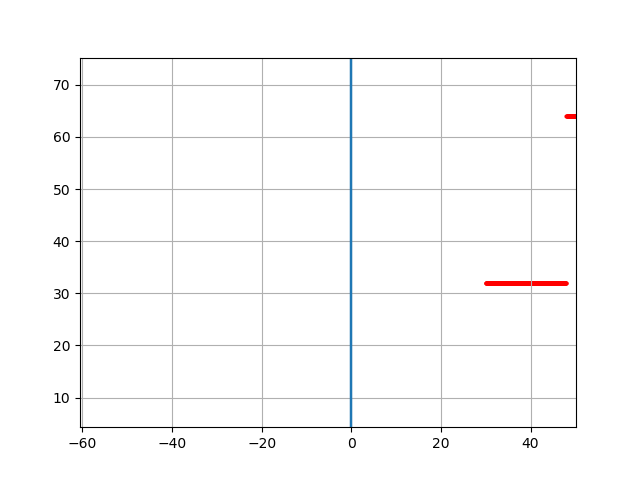

In [30]:
set_posit_env(8, 0)
for p in np.linspace(30, 100, 1000):
#     print(Posit(p))
    plt.scatter(p, Posit(p),marker='.', c='r', linewidths=0.01)
# plt.axvline(x=1/64)
# plt.axvline(x=1/(64**2))
# plt.axvline(x=(1/(64**2)+1/64)/2)
# plt.axvline(x=-1/64)
# plt.axvline(x=-1/(64**2))
# plt.axvline(x=-(1/(64**2)+1/64)/2)
plt.scatter(0,0,marker='.', c='r', linewidths=0.01)
plt.grid(True)
plt.show()

In [12]:
from ctypes import c_ulonglong, c_double

x = 1/(64)-0.0001
n = c_ulonglong.from_buffer(c_double(x)).value
print(n) # n = 0
sign = n >> 63
print(sign)
# to get exponent bits, remove sign, shift, then subtract bias
exponents = ((n & ((1 << 63) - 1)) >> 52) - 1023  
print(exponents)
# to get fractions bits, mask fraction bits and then OR the hidden bit
fraction = (1 << 52) | (n & ((1 << 52) - 1))
print(fraction)
# self.number = self.construct_posit(sign, exponent, fraction).number

4580103174960564090
0
-7
8949553179510650


In [13]:
Posit(x).decode()

(0, 0, 0, 0)

In [16]:
# construct_posit(sign, exponent, fraction)
scale = exponents
n = 0
# regime = floor(scale / self.es)
regime = scale >> Posit.ES
print(regime)
# exponent = scale % 2**es 
exponent = scale & createMask(Posit.ES, 0)
print(exponent)
# number of bits written for regime
regime_length = regime + 2 if regime >= 0 else - regime + 1
print(regime_length)
# overflow to maxpos underflow to minpos
# Check if this is the error with other posits
if regime_length >= Posit.NBITS :#+ 1:
    print('underflow')
    p = Posit(nbits = Posit.NBITS, es = Posit.ES)
    p.set_bit_pattern(Posit().maxpos if regime >= 0 else Posit().minpos)
    if sign == 1:
        p = -p
    print(p)

-7
0
8
underflow
0.015625


In [74]:
def set_float2(x):
        '''
            Input: Float
            Map float to posit
            Cases -> Action
                (1) negative or positive zero -> return zero posit
                (2) +-inf or NaN -> return posit infinity
                (3) normal float -> round to nearest representable posit
        '''
        if type(x) == float:
            print('Hi from float!')
            # (1) negative or positive zero -> return zero posit 
            if x == 0:
                return Posit().zero
            # (2) +-inf or NaN -> return posit infinity
            elif isinf(x) or isnan(x):
                return Posit().inf
            # (3) normal float
            else:
                # convert to integer
                n = Posit().float_to_int(x)
                # to get sign bit, shift 63 times to the right
                sign = n >> 63
                # to get exponent bits, remove sign, shift, then subtract bias
                exponent = ((n & ((1 << 63) - 1)) >> 52) - 1023  
                # to get fractions bits, mask fraction bits and then OR the hidden bit
                fraction = (1 << 52) | (n & ((1 << 52) - 1))
                # given the decoded values, construct a posit
                return construct_posit2(sign, exponent, fraction).number

In [75]:
def construct_posit2(sign, scale, fraction):
    print('Hi from construct!')
    if fraction == 0:
        return Posit(nbits = Posit.NBITS, es = Posit.ES)
    n = 0
    # regime = floor(scale / self.es)
    regime = scale >> Posit.ES
    # exponent = scale % 2**es 
    exponent = scale & createMask(Posit.ES, 0)

    # number of bits written for regime
    regime_length = regime + 2 if regime >= 0 else - regime + 1

    # overflow to maxpos underflow to minpos
    if regime_length >= Posit.NBITS:
        p = Posit(nbits = Posit.NBITS, es = Posit.ES)
        p.set_bit_pattern(Posit().maxpos if regime >= 0 else Posit().minpos)
        if sign == 1:
            p = -p
        return p

    # encode regime
    if regime >= 0:
        n |= createMask(regime_length - 1, Posit.NBITS - regime_length)
    elif Posit.NBITS - 1 >= regime_length:
        n |= setBit(n, Posit.NBITS - 1 - regime_length)

    # count number of bits available for exponent and fraction
    exponent_bits = min(Posit.ES, Posit.NBITS - 1 - regime_length)
    fraction_bits = Posit.NBITS - 1 - regime_length - exponent_bits

    # remove trailing zeroes
    fraction = removeTrailingZeroes(fraction)
    # length of fraction bits, -1 is for hidden bit
    fraction_length = countBits(fraction) - 1
    # remove hidden bit
    fraction &= 2**(countBits(fraction)-1) - 1

    # trailing_bits = number of bits available for exponent + fraction
    trailing_bits = Posit.NBITS - 1 - regime_length
    # exp_frac = concatenate exponent + fraction without trailing zeroes
    exp_frac = removeTrailingZeroes(exponent << (fraction_length) | fraction)

    # exp_frac_bits = minimum number of bits needed to represent exp_frac
    # exponent only
    if fraction_length == 0:
        exp_frac_bits = Posit.ES - countTrailingZeroes(exponent)
    # exponent plus fraction
    else:
        exp_frac_bits = Posit.ES + fraction_length

    # rounding needs to be done
    if trailing_bits < exp_frac_bits:
        # get overflow bits
        overflown = exp_frac & createMask(exp_frac_bits - trailing_bits, 0)
        # truncate trailing bits, encode to number
        n |= exp_frac >> (exp_frac_bits - trailing_bits)
        # perform round to even rounding by adding last bit to overflown bit
        # tie-breaking
        if overflown == (1 << (exp_frac_bits - trailing_bits - 1)):
            # check last bit
            if checkBit(exp_frac, exp_frac_bits - trailing_bits):
                n += 1
        # round to next higher value
        elif overflown > (1 << (exp_frac_bits - trailing_bits - 1)):
            n += 1
        # round to next lower value
        else:
            None
    else:
        n |= exp_frac << (trailing_bits - exp_frac_bits)

    p = Posit(nbits = Posit.NBITS, es = Posit.ES)
    if sign == 0:
        p.set_bit_pattern(n)
    else:
        p.set_bit_pattern(twosComplement(n, Posit.NBITS))

    return p

In [93]:
print(set_float2(649999999.))

Hi from float!
Hi from construct!
127


In [73]:
Posit().zero

0